### Problem Statement - Table 2:,  make a csv from the prompt.

Approach I tried : 
- Convert the pages to images.
- Using table-transformer-detector to detect the table in the image and return the bounding box.
- Once we get the bounding box , we can crop the table portion from the image.
- Give the extracted table image as input to Gemini & get the comman separated response
- Once we have csv text , convert to df and save it as .csv.

In [4]:
from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

/Users/uzair/miniconda3/envs/tables/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/Users/uzair/miniconda3/envs/tables/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


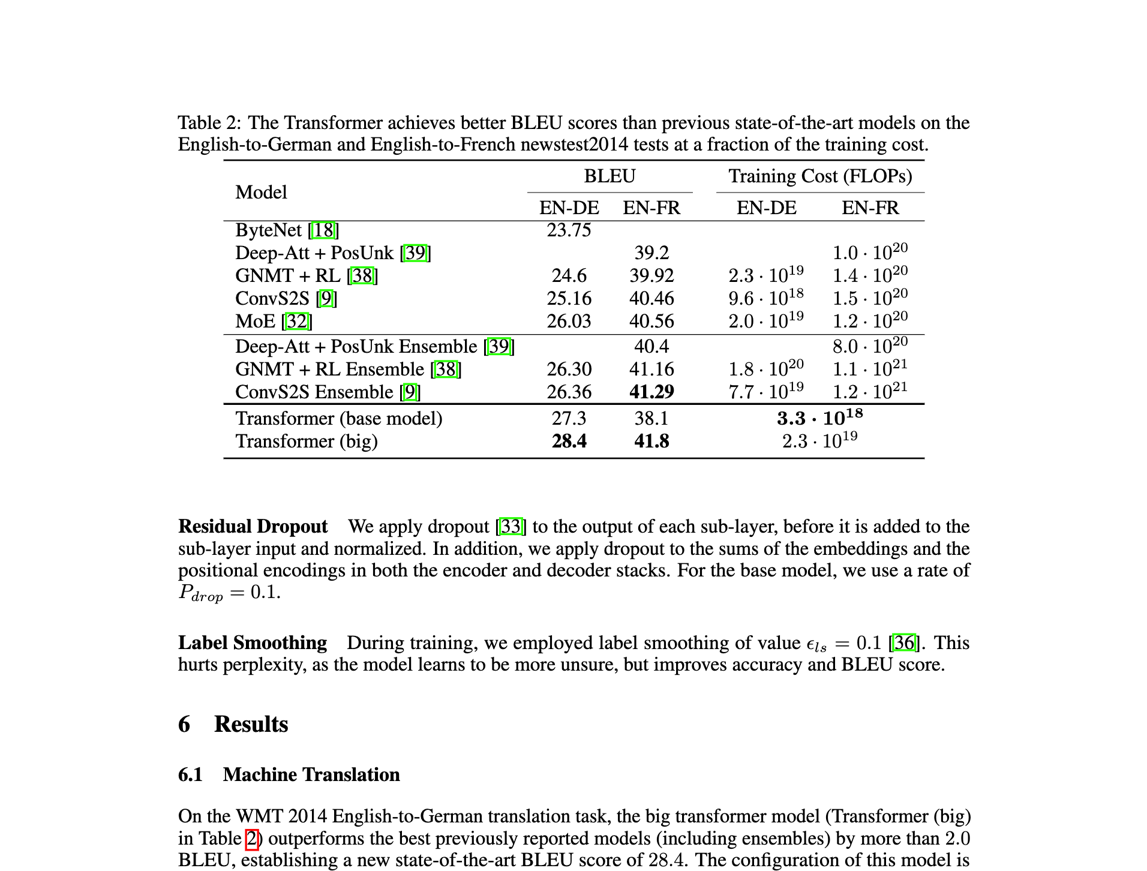

In [1]:
from PIL import Image
from huggingface_hub import hf_hub_download

# let's load an example image
file_path = "/Users/uzair/tech_fusion/tablepage.png"
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

In [2]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

cpu


In [6]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 608, 800])


In [7]:
with torch.no_grad():
  outputs = model(pixel_values)

In [8]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [9]:
objects = outputs_to_objects(outputs, image.size, id2label)
bbox = objects[0]["bbox"]

In [10]:
def extract_bbox(image_path, bbox, output_path):
    image = Image.open(image_path)
    bbox_image = image.crop(bbox)
    bbox_image = bbox_image.convert("RGB")  # Convert to RGB mode
    bbox_image.save(output_path, "JPEG")   
    

In [11]:
image_path = "/Users/uzair/tech_fusion/tablepage.png"
bbox = bbox
output_path = "path_to_save_extracted_image.jpg"
extract_bbox(image_path, bbox, output_path)

In [12]:
import PIL
img = PIL.Image.open('path_to_save_extracted_image.jpg')

### Giving extracted table image as input to Gemini

In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai
from IPython.display import Markdown
import PIL.Image
import os
import textwrap


In [15]:
gemini_models = [m for m in genai.list_models()]
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

In [16]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


In [17]:
model = genai.GenerativeModel("gemini-1.5-pro-latest")


In [69]:
def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, " ", predicate=lambda _: True))

In [55]:
response = model.generate_content(["Given a table in the image convert it into csv and return as csv.", img], stream=True)
response.resolve()

In [70]:
data = to_markdown(response.text)

In [71]:
data

 ```
 Model,EN-DE (BLEU),EN-FR (BLEU),EN-DE (FLOPs),EN-FR (FLOPs)
 ByteNet [18],23.75,,
 Deep-Att + PosUnk [39],,39.2,1.0 · 10^20,1.4 · 10^20 
 GNMT + RL [38],24.6,39.92,2.3 · 10^19,
 ConvS2S [9],25.16,40.46,9.6 · 10^18,1.5 · 10^20
 MoE [32],26.03,40.56,2.0 · 10^19,1.2 · 10^20
 Deep-Att + PosUnk Ensemble [39],,40.4,8.0 · 10^20,
 GNMT + RL Ensemble [38],26.30,41.16,1.8 · 10^20,1.1 · 10^21 
 ConvS2S Ensemble [9],26.36,41.29,7.7 · 10^19,1.2 · 10^21
 Transformer (base model),27.3,38.1,3.3 · 10^18,
 Transformer (big),28.4,41.8,2.3 · 10^19, 
 ``` 


In [72]:
with open("csv_from_table.csv","w") as f:
    f.write(str(data.data))

In [73]:
import pandas as pd
y = pd.read_csv("csv_from_table.csv")

### Final DataFrame

In [74]:
y

,,,,```
Model,EN-DE (BLEU),EN-FR (BLEU),EN-DE (FLOPs),EN-FR (FLOPs)
ByteNet [18],23.75,NaN,NaN,NaN
Deep-Att + PosUnk [39],NaN,39.2,1.0 · 10^20,1.4 · 10^20
GNMT + RL [38],24.6,39.92,2.3 · 10^19,NaN
ConvS2S [9],25.16,40.46,9.6 · 10^18,1.5 · 10^20
MoE [32],26.03,40.56,2.0 · 10^19,1.2 · 10^20
Deep-Att + PosUnk Ensemble [39],NaN,40.4,8.0 · 10^20,NaN
GNMT + RL Ensemble [38],26.30,41.16,1.8 · 10^20,1.1 · 10^21
ConvS2S Ensemble [9],26.36,41.29,7.7 · 10^19,1.2 · 10^21
Transformer (base model),27.3,38.1,3.3 · 10^18,NaN
